In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from google.colab import drive
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [8]:
df = pd.read_csv('Dataset.csv')
df.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [9]:
df = df.sample(frac = 1)

from sklearn.model_selection import train_test_split
text = df['Text'].values
label = df['Sentiment'].values
text_train, text_test, label_train, label_test = train_test_split(text, label, test_size=0.20, random_state=20)

In [10]:
df.head()

,Text,Sentiment
85,DDD IDCC continue higher,1
86,"Had hoped to pick up some OST today, but looks...",1
238,ko has trouble staying above 200 day sma past ...,-1
5247,James Dinsmore attributes Bancroft Fundâ€™s un...,-1
4811,NVDA has started to bounce & broke out from a ...,1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5791 entries, 85 to 3372
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 135.7+ KB


# One hot embedding + CNN

In [12]:
 from keras.preprocessing.text import Tokenizer
 tokenizer = Tokenizer()
 tokenizer.fit_on_texts(text_train)
 Xcnn_train = tokenizer.texts_to_sequences(text_train)
 Xcnn_test = tokenizer.texts_to_sequences(text_test)
 vocab_size = len(tokenizer.word_index)+1
 print(text_train[1])
 print(Xcnn_train[1]) 

My setup alerts went bonkers today..One of many that got triggered.Cup+Handle breakout in PFE   
[52, 368, 2235, 556, 4066, 27, 79, 7, 267, 32, 315, 622, 467, 510, 99, 5, 1367]


In [13]:
 from keras.preprocessing.sequence import pad_sequences
 maxlen = 150
 Xcnn_train = pad_sequences(Xcnn_train, padding='post', maxlen=maxlen)
 Xcnn_test = pad_sequences(Xcnn_test, padding='post', maxlen=maxlen)
 print(Xcnn_train[0, :]) 

[ 661   46 4065    2  555  799 1109  177  285 1559 1366  861   55   78
  158   26  862   57 2233    7 2234   24   62  932   19    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


In [14]:
from keras.models import Sequential
from keras import layers 
import tensorflow as tf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 200)          1802200   
                                                                 
 conv1d (Conv1D)             (None, 149, 256)          102656    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 74, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 128)           98432     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 36, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 33, 64)            3

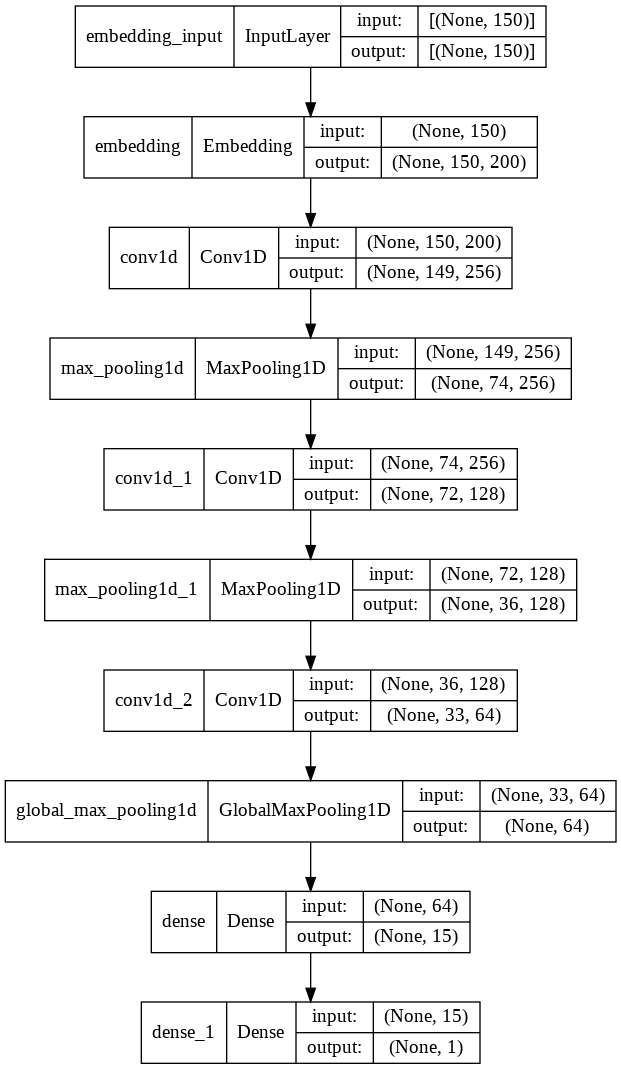

In [15]:
seed = 160104069
torch.manual_seed(seed)
embedding_dim = 200
textcnnmodel = Sequential()
textcnnmodel.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
textcnnmodel.add(layers.Conv1D(filters=256, kernel_size=2, activation='relu'))
textcnnmodel.add(layers.MaxPooling1D(pool_size = 2))
textcnnmodel.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
textcnnmodel.add(layers.MaxPooling1D(pool_size = 2))
textcnnmodel.add(layers.Conv1D(filters=64, kernel_size=4, activation='relu'))
textcnnmodel.add(layers.GlobalMaxPooling1D())
textcnnmodel.add(layers.Dense(15, activation='relu'))
textcnnmodel.add(layers.Dense(1, activation='sigmoid'))
textcnnmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
textcnnmodel.summary() 

tf.keras.utils.plot_model(textcnnmodel, show_shapes = True, show_layer_names = True)

In [16]:
history = textcnnmodel.fit(Xcnn_train, label_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(Xcnn_test, label_test),
                    batch_size=10)
loss, accuracy = textcnnmodel.evaluate(Xcnn_train, label_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = textcnnmodel.evaluate(Xcnn_test, label_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/10
464/464 [==============================] - 29s 61ms/step - loss: -148617.3281 - accuracy: 0.1926 - val_loss: -1141072.8750 - val_accuracy: 0.3115
Epoch 2/10
464/464 [==============================] - 31s 66ms/step - loss: -66077604.0000 - accuracy: 0.2899 - val_loss: -192089520.0000 - val_accuracy: 0.3236
Epoch 3/10
464/464 [==============================] - 28s 61ms/step - loss: -1723665664.0000 - accuracy: 0.2904 - val_loss: -2915102208.0000 - val_accuracy: 0.3123
Epoch 4/10
464/464 [==============================] - 28s 61ms/step - loss: -14247025664.0000 - accuracy: 0.2997 - val_loss: -16322300928.0000 - val_accuracy: 0.2856
Epoch 5/10
464/464 [==============================] - 28s 61ms/step - loss: -61356843008.0000 - accuracy: 0.2994 - val_loss: -58463367168.0000 - val_accuracy: 0.2865
Epoch 6/10
464/464 [==============================] - 28s 61ms/step - loss: -190400135168.0000 - accuracy: 0.3061 - val_loss: -157250207744.0000 - val_accuracy: 0.2882
Epoch 7/10
464/464

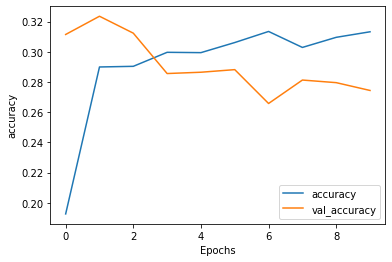

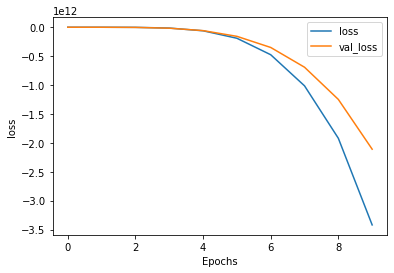

In [17]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [18]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

y_pred = textcnnmodel.predict(Xcnn_train)

y_pred = np.where(y_pred > 0, 1, -1)
y_pred = np.reshape(y_pred, (y_pred.shape[0]))

loss, accuracy = textcnnmodel.evaluate(Xcnn_train, label_train, verbose = 1)

145/145 [==============================] - 5s 31ms/step - loss: -4499073138688.0000 - accuracy: 0.3446


In [19]:
print('Train Loss:', loss)
print('Train Accuracy:', accuracy, '(Model Metric)')
print('Train Accuracy:', accuracy_score(label_train, y_pred), '(sklearn Metric)')
print('Train Precision:', precision_score(label_train, y_pred))
print('Train Recall:', recall_score(label_train, y_pred))
print('Train F1-score:', f1_score(label_train, y_pred))

Train Loss: -4499073138688.0
Train Accuracy: 0.34455958008766174 (Model Metric)
Train Accuracy: 0.7055267702936097 (sklearn Metric)
Train Precision: 0.9767441860465116
Train Recall: 0.5462012320328542
Train F1-score: 0.7006145741878841


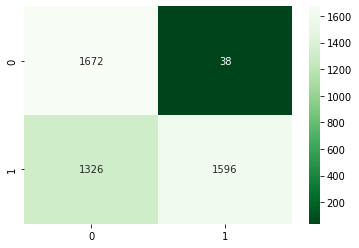

In [20]:
sns.heatmap(confusion_matrix(label_train, y_pred), annot = True, fmt = 'g', cmap='Greens_r')

In [21]:
y_pred = textcnnmodel.predict(Xcnn_test)

y_pred = np.where(y_pred > 0, 1, -1)
y_pred = np.reshape(y_pred, (y_pred.shape[0]))

Test Accuracy: 0.5979292493528904 (sklearn Metric)


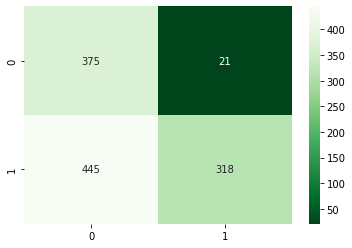

In [22]:
print('Test Accuracy:', accuracy_score(label_test, y_pred), '(sklearn Metric)')
sns.heatmap(confusion_matrix(label_test, y_pred), annot = True, fmt = 'g', cmap='Greens_r')

# BOW + NN

In [23]:
# get a word count per of text
def word_count(words):
    return len(words.split())

In [24]:
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize, WordNetLemmatizer
import nltk
import re 
import string
import pickle
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [25]:
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))
print(stop_words)

{'y', 'himself', 'above', 'will', 'couldn', 'on', 'should', 'herself', 'below', 'itself', 'were', 'very', 'ain', 'for', 'but', 'to', 'those', 'wouldn', 'mightn', 'hasn', 'there', 'just', 'him', "isn't", 'doing', 'themselves', 'most', 'being', 'out', 'down', 'be', 'ourselves', 'he', "haven't", 'we', 'during', "you've", "doesn't", 'o', 'few', 'didn', 'this', "you'll", 'doesn', 'where', "you'd", "she's", 'her', 'did', 'needn', "hasn't", 'can', 'they', 'had', 'these', "shan't", 'our', 'than', 'again', 'my', "should've", "didn't", 'from', 'yours', 'which', 'your', 'because', 'now', 'off', 'me', 'not', 'so', 'd', 'with', "you're", 'am', 'has', 'wasn', 'whom', 'only', 'such', 't', 'them', 'are', "that'll", 'what', 'the', 'when', "mustn't", 'his', 'hers', 'll', 'm', 'that', "it's", 'and', 'is', 'against', 'was', 'then', 'more', 'of', 'if', 'in', 'further', 'once', 'any', 's', 'mustn', 'as', 'at', 'before', 'don', "aren't", 'up', 'nor', 'by', "shouldn't", "mightn't", "hadn't", 'having', 'some',

In [26]:
word_list = list()
for i in range(len(df)):
    li = df.Text[i].split()
    for k in li:
        word_list.append(k)

In [27]:
from collections import Counter 
wordCounter = Counter(word_list)
countedWordDict = dict(wordCounter)
sortedWordDict = sorted(countedWordDict.items(),key = lambda x : x[1],reverse=True)
sortedWordDict[0:20]

[('the', 1796),
 ('to', 1668),
 ('a', 1280),
 ('on', 1032),
 ('of', 944),
 ('in', 891),
 ('AAP', 884),
 ('for', 868),
 ('and', 850),
 ('is', 811),
 ('-', 728),
 ('at', 541),
 ('this', 461),
 ('it', 454),
 ('I', 453),
 ('up', 357),
 ('user:', 340),
 ('from', 331),
 ('will', 330),
 ('be', 324)]

In [28]:
seed = 160104069
torch.manual_seed(seed)

In [29]:
df["Sentiment"] = df["Sentiment"].replace(-1,0)
df["Sentiment"].value_counts()

1    3685
0    2106
Name: Sentiment, dtype: int64

In [30]:
#Checking if any null values present
(df.isnull().sum() / len(df))*100

Text         0.0
Sentiment    0.0
dtype: float64

In [31]:
ps = PorterStemmer()
lemma = WordNetLemmatizer()
stopwordSet = set(stopwords.words("english"))

In [32]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
def process_text(text):
  # Lower Casing
    text = text.lower()
    text=text[1:]
    # Removing all URls 
    text = re.sub(urlPattern,'',text)
    # Removing all @username.
    text = re.sub(userPattern,'',text) 
    #Remove punctuations
    text = text.translate(str.maketrans("","",string.punctuation))
    #tokenizing words
    tokens = word_tokenize(text)
    #Removing Stop Words
    final_tokens = [w for w in tokens if w not in stopwordSet]
    #reducing a word to its word stem 
    wordLemm = WordNetLemmatizer()
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        finalwords.append(word)
    return ' '.join(finalwords)   

In [33]:
df['processed_text'] = df['Text'].apply(lambda x: process_text(x))
print('Text Preprocessing complete.')

Text Preprocessing complete.


In [34]:
print(df.shape)
df

(5791, 3)


,Text,Sentiment,processed_text
85,DDD IDCC continue higher,1,dd idcc continue higher
86,"Had hoped to pick up some OST today, but looks...",1,ad hoped pick ost today look like im day late ...
238,ko has trouble staying above 200 day sma past ...,0,trouble staying 200 day sma past week could sh...
5247,James Dinsmore attributes Bancroft Fundâ€™s un...,0,ames dinsmore attribute bancroft fundâ€™s unus...
4811,NVDA has started to bounce & broke out from a ...,1,vda started bounce broke falling wedge closing...
...,...,...,...
2487,CST - 150% avg daily volume. ooks good for hig...,1,st 150 avg daily volume ooks good higher next ...
2593,DVAX buzz around this stock now - will be in p...,1,vax buzz around stock play tuesday news limite...
3352,"NKD I am a golden God, do not fight me",1,kd golden god fight
3175,JCP Time for user to pound on balance sheet an...,0,cp time user pound balance sheet cash issue


In [35]:
cv = CountVectorizer(max_features = len(df))
X = cv.fit_transform(df['processed_text']).toarray()
y= df['Sentiment'].to_numpy()

#X = torch.from_numpy(X).type(torch.LongTensor)
#y = torch.from_numpy(y).type(torch.LongTensor)

X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [36]:
## Split the dataset into Training and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state = seed)

X_train = X_train.type(torch.FloatTensor)
X_test = X_test.type(torch.FloatTensor)
y_train = y_train.type(torch.FloatTensor)
y_test = y_test.type(torch.FloatTensor)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [37]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 512) 
        self.layer_2 = nn.Linear(512, 128) 
        self.layer_3 = nn.Linear(128, 1)   
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout()
        # self.flatten = nn.Flatten()

        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_3(x)
        logits = self.sigmoid(x)
        return logits

In [38]:
model = NeuralNetwork(len(df))
print(model)

NeuralNetwork(
  (layer_1): Linear(in_features=5791, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [39]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())

loss_fn = nn.BCEWithLogitsLoss()
model = model.to(device)

loss_fn = loss_fn.to(device)

In [40]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [41]:
def trainModel(model, loss_fn, optimizer):
    model.train()

    batch = 256
    size = X_test.shape[0]

    loss = 0
    acc = 0
    

    for i in range(X_train.shape[0]):
      x, y = X_train[i], torch.tensor([y_train[i]], dtype=torch.float)
    
      # Compute prediction 
      pred = model(x)
      loss += loss_fn(pred,y)
      acc += binary_accuracy(pred,y)
      
      if i>0 and (i+1)%batch == 0:
          # Backpropagation
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
         # print(f'Training Loss: {loss.item():.4f}', end="\r")
         # print(f'\tTraining Loss: {loss.item():.3f} | Training Acc: {acc.item()*100:.2f}%')
          loss = 0
          acc = 0
    print()
    return loss.item()/size, acc.item()/size

In [42]:
from numpy.lib.function_base import append

TP=[]
TN=[]
FP=[]
FN=[]
def testModel(model, loss_fn):
    model.eval()
    size = X_test.shape[0]
    loss = 0
    acc = 0
    with torch.no_grad():
      for i in range(X_test.shape[0]):
        x, y = X_test[i], torch.tensor([y_test[i]], dtype=torch.float)
    
        # Compute prediction error
        pred = model(x)
        if( (torch.round(pred)) == 1 and y== 0) :
           FP.append(1)
        if( (torch.round(pred)) == 0 and y== 1) :
           FN.append(1)
        if( (torch.round(pred)) == 1 and y== 1) :
           TP.append(1)
        if( (torch.round(pred)) == 0 and y== 0) :
           TP.append(1)         
       
            
        loss += loss_fn(pred, y).item()
        acc += binary_accuracy(pred,y).item()
      
    loss /= size
    acc /= size
    
    #print(f'Testing Loss: {loss}')
    #print(f'\t Val. Loss: {loss:.3f} |  Val. Acc: {acc*100:.2f}%')
  
    return loss, acc  

In [43]:
epochs = 1
best_valid_loss = float('inf')

# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):

    train_loss,train_acc = trainModel(model, loss_fn, optimizer)
    valid_loss, valid_acc = testModel(model, loss_fn)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'stock_sentiment.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    epoch_tr_loss.append(train_loss)
    epoch_vl_loss.append(valid_loss)
    epoch_tr_acc.append(train_acc)
    epoch_vl_acc.append(valid_acc)


	Train Loss: 0.012 | Train Acc: 1.55%
	 Val. Loss: 0.639 |  Val. Acc: 65.66%


In [44]:
TP=len(TP)
TN=len(TN)
FP=len(FP)
FN=len(FN)

In [45]:
acc=(TP+TN)/(TP+TN+FN+FP)
acc

0.7463330457290768

In [46]:
prec=TP/(TP+FP)
prec

0.8826530612244898

In [47]:
rec=TP/(TP+FN)
rec

0.828544061302682

In [48]:
f1score=2*prec*rec/(prec+rec)
f1score

0.8547430830039525

# TF-IDF + NN

In [49]:
tfidf = TfidfVectorizer( ngram_range=(1,3), analyzer='char')
X = cv.fit_transform(df['processed_text']).toarray()
y= df['Sentiment'].to_numpy()

X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [50]:
## Split the dataset into Training and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state = seed)

X_train = X_train.type(torch.FloatTensor)
X_test = X_test.type(torch.FloatTensor)
y_train = y_train.type(torch.FloatTensor)
y_test = y_test.type(torch.FloatTensor)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [51]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 512) 
        self.layer_2 = nn.Linear(512, 128) 
        self.layer_3 = nn.Linear(128, 1)   
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout()
        # self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_3(x)
        logits = self.sigmoid(x)
        return logits

In [52]:
model = NeuralNetwork(len(df))
print(model)

NeuralNetwork(
  (layer_1): Linear(in_features=5791, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [53]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())

loss_fn = nn.BCEWithLogitsLoss()
model = model.to(device)
loss_fn = loss_fn.to(device)

In [54]:
def binary_accuracy(preds, y):

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [55]:
def trainModel(model, loss_fn, optimizer):
    model.train()

    batch = 256
    size = X_test.shape[0]

    loss = 0
    acc = 0
    

    for i in range(X_train.shape[0]):
      x, y = X_train[i], torch.tensor([y_train[i]], dtype=torch.float)
    
      # Compute prediction 
      pred = model(x)
      loss += loss_fn(pred,y)
      acc += binary_accuracy(pred,y)
      
      if i>0 and (i+1)%batch == 0:
          # Backpropagation
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
         # print(f'Training Loss: {loss.item():.4f}', end="\r")
         # print(f'\tTraining Loss: {loss.item():.3f} | Training Acc: {acc.item()*100:.2f}%')
          loss = 0
          acc = 0
    print()
    return loss.item()/size, acc.item()/size

In [56]:
from numpy.lib.function_base import append

TP=[]
TN=[]
FP=[]
FN=[]
def testModel(model, loss_fn):
    model.eval()
    size = X_test.shape[0]
    loss = 0
    acc = 0
    
    with torch.no_grad():
      for i in range(X_test.shape[0]):
        x, y = X_test[i], torch.tensor([y_test[i]], dtype=torch.float)
    
        # Compute prediction error
        pred = model(x)
        if( (torch.round(pred)) == 1 and y== 0) :
           FP.append(1)
        if( (torch.round(pred)) == 0 and y== 1) :
           FN.append(1)
        if( (torch.round(pred)) == 1 and y== 1) :
           TP.append(1)
        if( (torch.round(pred)) == 0 and y== 0) :
           TP.append(1)         
       
            
        loss += loss_fn(pred, y).item()
        acc += binary_accuracy(pred,y).item()
      
    loss /= size
    acc /= size
    
    #print(f'Testing Loss: {loss}')
    #print(f'\t Val. Loss: {loss:.3f} |  Val. Acc: {acc*100:.2f}%')
  
    return loss, acc

In [57]:
epochs = 1
best_valid_loss = float('inf')

# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):

    train_loss,train_acc = trainModel(model, loss_fn, optimizer)
    valid_loss, valid_acc = testModel(model, loss_fn)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'stock_sentiment.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    epoch_tr_loss.append(train_loss)
    epoch_vl_loss.append(valid_loss)
    epoch_tr_acc.append(train_acc)
    epoch_vl_acc.append(valid_acc)


	Train Loss: 0.012 | Train Acc: 1.55%
	 Val. Loss: 0.637 |  Val. Acc: 65.66%


In [58]:
TP=len(TP)
TN=len(TN)
FP=len(FP)
FN=len(FN)

In [59]:
acc=(TP+TN)/(TP+TN+FN+FP)
acc

0.7437446074201898

In [60]:
prec=TP/(TP+FP)
prec

0.785063752276867

In [61]:
rec=TP/(TP+FN)
rec

0.933911159263272

In [62]:
f1score=2*prec*rec/(prec+rec)
f1score

0.8530430479960415